# Analysis Introduction

## Overview

This analysis explores the relationship between prescription drug utilization and key health measures at the state level. By cross-referencing specific medications with corresponding health conditions, the analysis aims to uncover patterns and correlations that could inform healthcare policies and decision-making.

---

## Objectives

The primary objectives of this analysis are to:
1. **Examine the correlation** between average drug costs and aggregated health measures across different states.
2. **Identify utilization patterns** of specific drugs in relation to the prevalence of chronic conditions.
3. **Understand the geographic distribution** of prescription drug claims in relation to health outcomes.

---

## Key Questions

To guide the analysis, the following key questions were posed:

### 1. **How do state-level health measures correlate with the average cost of prescription drugs?**
   - Are there states where higher prevalence of certain conditions is associated with increased drug costs?
   - Which conditions show the strongest correlations between health outcomes and prescription costs?

### 2. **What are the total claims for identified drugs across states with different health measures?**
   - How does the utilization of certain drugs vary across states with varying levels of chronic condition prevalence?
   - Are there drugs that are disproportionately prescribed in states with high levels of specific health measures?

### 3. **Which states have the highest and lowest utilization of specific drugs for their corresponding health measures?**
   - What patterns emerge when comparing drug utilization across states with different health outcomes?
   - How do these patterns inform understanding of healthcare needs and resource allocation?

---

## Methodology

The analysis was conducted using the following steps:

1. **Data Collection and Preparation**:
   - Data was collected from CDC and CMS datasets, focusing on chronic health conditions and prescription drug information.
   - The health measures data was aggregated from the county level to the state level to align with prescription data.

2. **Data Merging and Cross-Section Analysis**:
   - The datasets were merged on key identifiers such as geographic region (`GEO_VALUE`), health measure (`Measure_Short`), and drug name (`Gnrc_Name`).
   - The cross-section between the identified medications and health measures was analyzed to explore the relationships between these variables.

3. **Statistical and Visual Analysis**:
   - SQL queries were used to extract relevant subsets of data, which were then loaded into Python for further analysis.
   - Statistical methods and visualizations were employed to highlight key findings and trends.

---

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# Connect to the SQLite database
os.chdir('..')
cwd = os.getcwd()

db_path = cwd + '/data/db/chronic_conditions_prescriptions_database.db'
conn = sqlite3.connect(db_path)

### **1. Correlation Between Health Measures and Average Drug Costs**

Correlation Between Health Measures and Average Drug Costs:
         State     Condition            Drug_Name  Avg_Drug_Cost  \
0  Mississippi  Hypertension             Atenolol     394778.530   
1  Mississippi  Hypertension           Carvedilol    1132343.335   
2  Mississippi  Hypertension            Clonidine     767542.280   
3  Mississippi  Hypertension           Furosemide     819322.850   
4  Mississippi  Hypertension  Hydrochlorothiazide     952292.620   

   Health_Measure_Average  
0               42.678909  
1               42.678909  
2               42.678909  
3               42.678909  
4               42.678909  


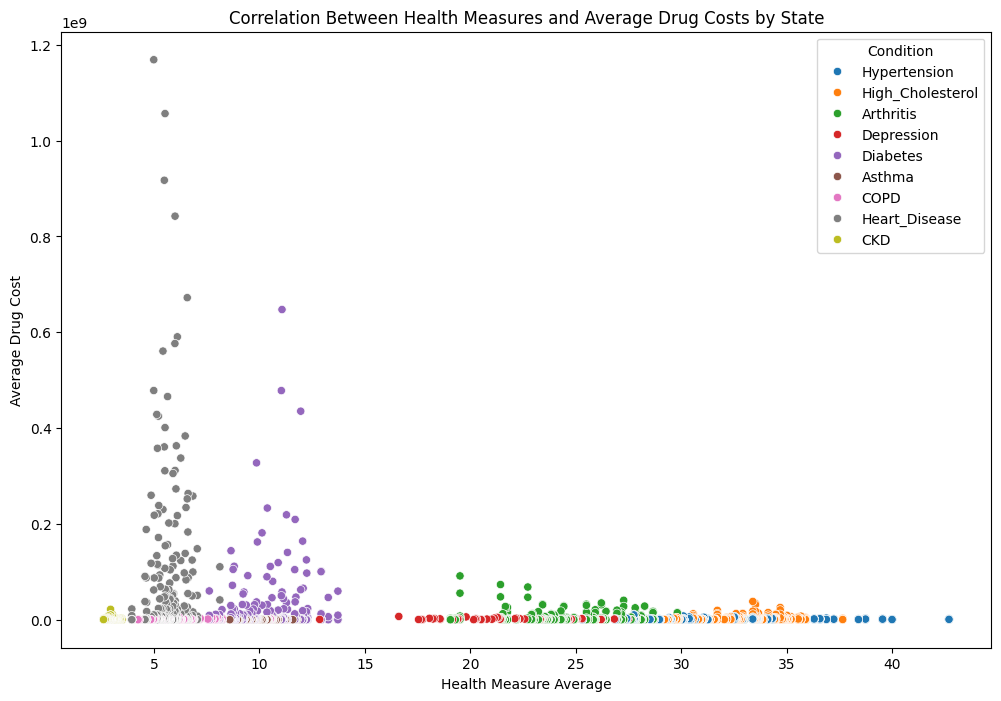

In [3]:
# SQL Query: Correlation Between Health Measures and Average Drug Costs
query = """
SELECT 
    GEO_VALUE AS State,
    Measure_Short AS Condition,
    Gnrc_Name AS Drug_Name,
    AVG(Tot_Drug_Cst) AS Avg_Drug_Cost,
    Weighted_Average AS Health_Measure_Average
FROM 
    final_merged_data
GROUP BY 
    GEO_VALUE, Measure_Short, Gnrc_Name, Weighted_Average
ORDER BY 
    Health_Measure_Average DESC;
"""

# Load the data into a DataFrame
correlation_df = pd.read_sql_query(query, conn)

# Display the results
print("Correlation Between Health Measures and Average Drug Costs:")
print(correlation_df.head())

# Plotting the relationship
plt.figure(figsize=(12, 8))
sns.scatterplot(data=correlation_df, x='Health_Measure_Average', y='Avg_Drug_Cost', hue='Condition')
plt.title('Correlation Between Health Measures and Average Drug Costs by State')
plt.xlabel('Health Measure Average')
plt.ylabel('Average Drug Cost')
plt.legend(title='Condition')
plt.show()

### **2. Total Claims for Identified Drugs Across States**

### **3. Drug Utilization Patterns by Condition and State**